In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from statsmodels.tsa.stattools import adfuller, kpss
#from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
def plot_graph(y_test, y_pred, title):
    plt.plot(y_test, label='y_true')
    plt.plot(y_pred, label='y_pred')
    plt.legend()
    plt.title(title)
    plt.ylabel("Gold Week Price")
    plt.show()

In [26]:
gold = pd.read_csv('ouro2.csv')
gold.head()

,Data,Valor
0,13/06/2021,1868.0
1,06/06/2021,1879.6
2,30/05/2021,1892.0
3,23/05/2021,1905.3
4,16/05/2021,1878.9


In [27]:
gold.columns = ['data', 'today_price']
gold['data']= pd.to_datetime(gold.data)
gold.head()

,data,today_price
0,2021-06-13,1868.0
1,2021-06-06,1879.6
2,2021-05-30,1892.0
3,2021-05-23,1905.3
4,2021-05-16,1878.9


In [28]:
gold = gold[::-1]
gold.head()

,data,today_price
1095,2000-06-18,282.7
1094,2000-06-25,290.1
1093,2000-02-07,283.2
1092,2000-09-07,281.1
1091,2000-07-16,280.1


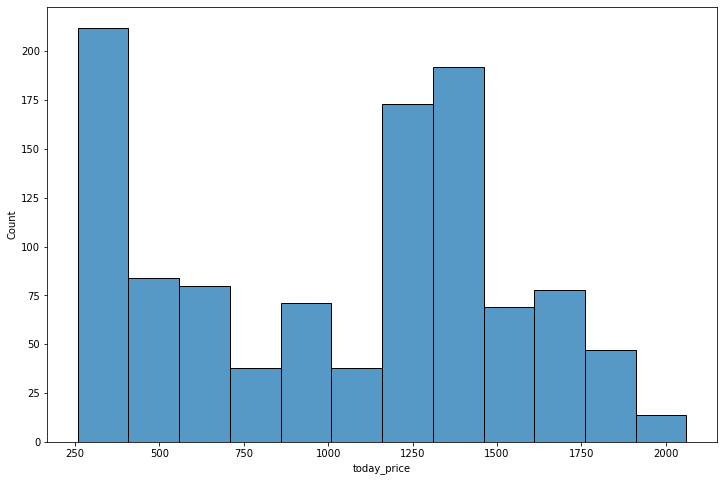

In [29]:
sns.histplot(gold.today_price)

### Normal series

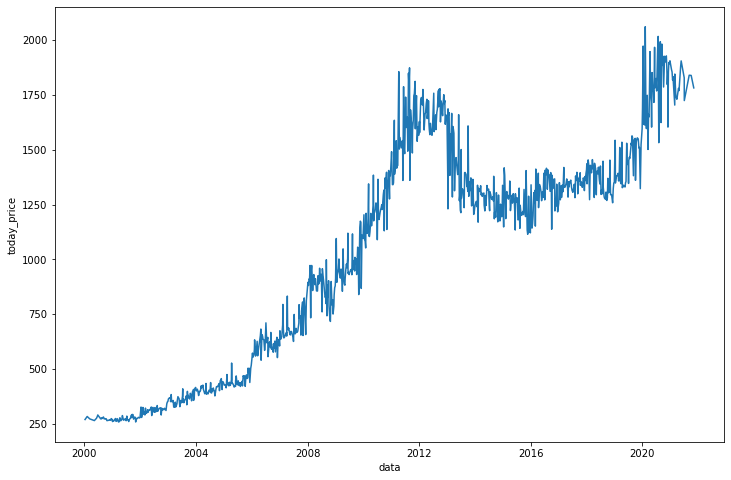

In [30]:
sns.lineplot(x=gold.data,y=gold.today_price)
# sns.lineplot(x=gold.data,y=gold.m7)
# sns.lineplot(x=gold.data,y=gold.m9)

In [37]:
# inverte dataframe para poder fazer as médias móveis com os valores corretos
gold = gold[::-1]

gold['last_week_price'] = gold.today_price.shift(1)
filtro = np.where(gold['today_price'] > gold['last_week_price'], 1, 0)
gold['target_subida'] = filtro
gold['next_week_price'] = gold.today_price.shift(-1)
gold['delta'] = gold.today_price - gold.last_week_price
gold['m3'] = gold.today_price.rolling(window=3).mean()
gold['m5'] = gold.today_price.rolling(window=5).mean()
gold['m7'] = gold.today_price.rolling(window=7).mean()
gold['m9'] = gold.today_price.rolling(window=9).mean()
gold.dropna(inplace=True)

# desinverte o dataframe para não precisar alterar o restante do notebook
gold = gold[::-1]
gold.head()

,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
1094,2000-06-25,290.1,283.2,1,282.7,6.9,284.800000,282.44,279.985714,278.977778
1093,2000-02-07,283.2,281.1,1,290.1,2.1,281.466667,278.94,278.085714,277.522222
1092,2000-09-07,281.1,280.1,1,283.2,1.0,279.633333,277.32,276.785714,276.422222
1091,2000-07-16,280.1,277.7,1,281.1,2.4,276.800000,276.46,276.200000,275.444444
1090,2000-07-23,277.7,272.6,1,280.1,5.1,275.133333,275.26,275.228571,274.522222


In [36]:
gold.tail()

,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
1091,2000-07-16,280.1,281.1,0,277.7,-1.0,281.466667,283.44,NaN,NaN
1092,2000-09-07,281.1,283.2,0,280.1,-2.1,284.800000,NaN,NaN,NaN
1093,2000-02-07,283.2,290.1,0,281.1,-6.9,285.333333,NaN,NaN,NaN
1094,2000-06-25,290.1,282.7,1,283.2,7.4,NaN,NaN,NaN,NaN
1095,2000-06-18,282.7,NaN,0,290.1,NaN,NaN,NaN,NaN,NaN


# Primeiros Experimentos:

Treinamento utilizando como conjunto de treino os preços atuais (today_price)
e target (next_week_price)


**entra preço -> prediz preço**

In [8]:
X_test_numpy = gold['today_price'][:100].to_numpy()
y_test_numpy = gold['next_week_price'][:100].to_numpy()
y_test = gold['next_week_price'][:100]
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test_numpy.shape, y_test.shape))

Número de linhas: (100,)
Número de colunas: (100,)


In [9]:
X_train_numpy = gold['today_price'][100:].to_numpy()
y_train_numpy = gold['next_week_price'][100:].to_numpy()
y_train = gold['next_week_price'][100:]
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train_numpy.shape, y_train.shape))

Número de linhas: (987,)
Número de colunas: (987,)


In [10]:
X_train_numpy = X_train_numpy.reshape(-1, 1)
X_test_numpy = X_test_numpy.reshape(-1, 1)

### Regressão Linear


RMSE  1899.9847490702052


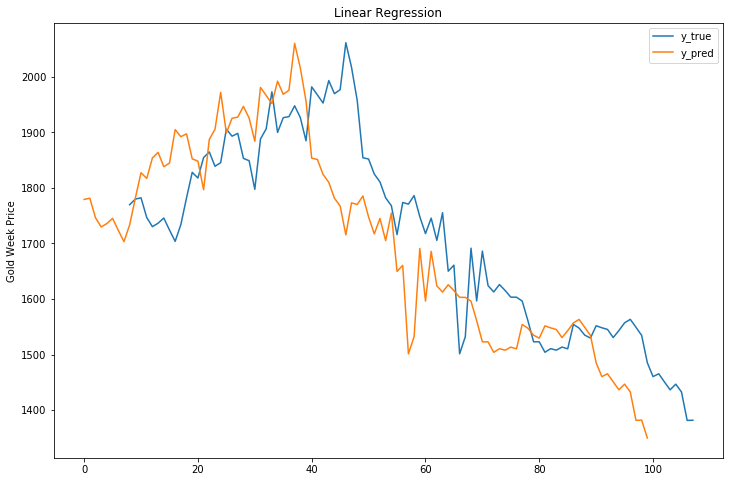

In [11]:
linear = LinearRegression().fit(X_train_numpy, y_train_numpy)
y_pred = linear.predict(X_test_numpy)
rmse = mean_squared_error(y_test, y_pred, squared=True)
print("RMSE ", rmse)
plot_graph(y_test, y_pred, "Linear Regression")

### Lasso

RMSE  1899.9847677889202


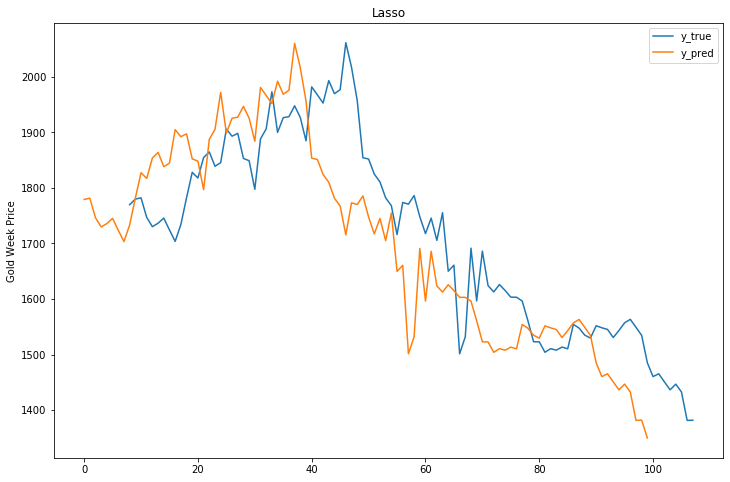

In [12]:
ridge = Ridge().fit(X_train_numpy, y_train_numpy)
y_pred = ridge.predict(X_test_numpy)
rmse = mean_squared_error(y_test, y_pred, squared=True)
print("RMSE ", rmse)
plot_graph(y_test, y_pred, "Lasso")

### Random Forest

RMSE  5080.635794382292


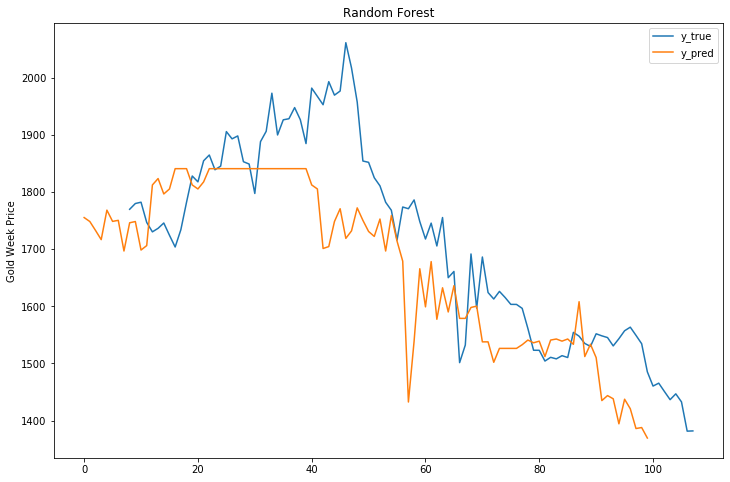

In [13]:
rf = RandomForestRegressor().fit(X_train_numpy, y_train_numpy)
y_pred = rf.predict(X_test_numpy)
rmse = mean_squared_error(y_test, y_pred, squared=True)
print("RMSE ", rmse)
plot_graph(y_test, y_pred, "Random Forest")

# Segunda leva de Experimentos:

Agora utilizaremos outros valores como médias móveis e delta de uma semana pra outras

**entra preço -> prediz preço**